In [1]:
# Importamos todas las librerías y recursos que necesitaremos

import numpy as np
import pandas as pd
import time

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import requests
from bs4 import BeautifulSoup

from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.common.by import By
PATH=ChromeDriverManager().install()

import warnings
warnings.filterwarnings('ignore')

In [66]:
#Primer vistazo a nuestra base de datos extraída de un archivo .csv

df_champ = pd.read_csv('../data/archive/lol_champs.csv')

df_champ.head(3)

,Unnamed: 0,Champions,HP,HP+,HP5,HP5+,MP,MP+,MP5,MP5+,AD,AD+,AS,AS+,AR,AR+,MR,MR+,MS,Range,Title,Release date,Last changed,Class(es),Legacy,Position(s),Resource,Range type,Adaptive type,Store price,Crafting,Style,Passive,Q Spell,W Spell,E Spell,Ultimate,Popularity,Winrate,BanRate,Mainedby,PentaKill,Gold,Minions,Wards,DamageDealt,KDA_kills,KDA_deaths,KDA_assists
0,0,Aatrox,580.0,90,3.0,1.0,0.0,0.0,0.0,0.0,60.0,5.0,0.651,+2.5%,38.0,3.25,32.0,1.25,345,175,the Darkin Blade,2013-06-13,V11.2,Juggernaut,Fighter Tank,Top Middle,Manaless ( Blood Well),Melee,Physical,4800 | 880,+ 2880,Damage3 Toughness3 Control2 Mobility2 Utili...,Deathbringer Stance,The Darkin Blade,Infernal Chains,Umbral Dash,World Ender,5.2%,50.4%,2.5%,0.6%,0.0017,"10,804",164.9,7.7,"19,100",5.7,5.7,6.0
1,1,Ahri,526.0,92,5.5,0.6,418.0,25.0,8.0,0.8,53.0,3.0,0.668,+2%,21.0,3.50,30.0,0.50,330,550,the Nine-Tailed Fox,2011-12-14,V11.11,Burst,Mage Assassin,Middle,Mana,Ranged,Magic,3150 | 790,+ 1890,Damage3 Toughness1 Control2 Mobility3 Utili...,Essence Theft,Orb of Deception,Fox-Fire,Charm,Spirit Rush,5.2%,51.6%,1.1%,0.6%,0.0003,"10,858",160.3,9.8,"19,146",6.2,5.4,7.8
2,2,Akali,500.0,105,8.0,0.5,200.0,0.0,50.0,0.0,62.0,3.3,0.625,+3.2%,23.0,3.50,37.0,1.25,345,125,the Rogue Assassin,2010-05-11,V11.14,Assassin,Assassin,Top Middle,Energy,Melee,Physical,3150 | 790,+ 1890,Damage3 Toughness1 Control1 Mobility3 Utili...,Assassin's Mark,Five Point Strike,Twilight Shroud,Shuriken Flip,Perfect Execution,5.9%,46.5%,7.0%,0.6%,0.0015,"10,786",151.1,7.9,"19,521",7.5,6.0,5.1


In [77]:
import pylab as plt
import seaborn as sns
def check_nan(df: pd.DataFrame) -> None:
    
    
    
    nan_cols = df.isna().mean()  * 100  

    display(f'N nan cols: {len(nan_cols[nan_cols>0])}')
    display(nan_cols[nan_cols>0])
    

    plt.figure(figsize=(5, 3))  

    sns.heatmap(df.isna(),   
                yticklabels=False,
                cmap='viridis',
                cbar=False
               )

    plt.show();

'N nan cols: 0'

Series([], dtype: float64)

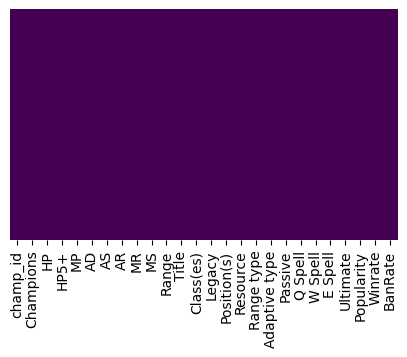

In [78]:
# Comprobamos si hay nulos

check_nan(df_champ)

In [69]:
# Eliminamos algunas columnas que no nos interesan de manera que nuestro df sea más manejable

df_champ = df_champ.drop(columns=['HP+', 'HP5', 'MP+', 'MP5', 'MP5+', 'AD+', 'AS+', 'AR+', 'MR+', 'Release date', 'Last changed', 'Store price', 'Crafting', 'Style', 'Mainedby', 'PentaKill', 'Gold', 'Minions', 'Wards', 'DamageDealt', 'KDA_kills', 'KDA_deaths', 'KDA_assists'])
df_champ.head()

,Unnamed: 0,Champions,HP,HP5+,MP,AD,AS,AR,MR,MS,Range,Title,Class(es),Legacy,Position(s),Resource,Range type,Adaptive type,Passive,Q Spell,W Spell,E Spell,Ultimate,Popularity,Winrate,BanRate
0,0,Aatrox,580.0,1.00,0.0,60.0,0.651,38.0,32.0,345,175,the Darkin Blade,Juggernaut,Fighter Tank,Top Middle,Manaless ( Blood Well),Melee,Physical,Deathbringer Stance,The Darkin Blade,Infernal Chains,Umbral Dash,World Ender,5.2%,50.4%,2.5%
1,1,Ahri,526.0,0.60,418.0,53.0,0.668,21.0,30.0,330,550,the Nine-Tailed Fox,Burst,Mage Assassin,Middle,Mana,Ranged,Magic,Essence Theft,Orb of Deception,Fox-Fire,Charm,Spirit Rush,5.2%,51.6%,1.1%
2,2,Akali,500.0,0.50,200.0,62.0,0.625,23.0,37.0,345,125,the Rogue Assassin,Assassin,Assassin,Top Middle,Energy,Melee,Physical,Assassin's Mark,Five Point Strike,Twilight Shroud,Shuriken Flip,Perfect Execution,5.9%,46.5%,7.0%
3,3,Akshan,560.0,0.65,350.0,52.0,0.638,26.0,30.0,330,500,the Rogue Sentinel,Marksman,Marksman Assassin,Middle,Mana,Ranged,Physical,Dirty Fighting,Avengerang,Going Rogue,Heroic Swing,Comeuppance,9.7%,50.1%,33.4%
4,4,Alistar,600.0,0.85,350.0,62.0,0.625,44.0,32.0,330,125,the Minotaur,Vanguard,Tank Support,Support,Mana,Melee,Magic,Triumphant Roar,Pulverize,Headbutt,Trample,Unbreakable Will,5.7%,49.8%,1.8%


In [70]:
# Cambiamos el nombre de la primera columna, la cual nos servirá de ID

df_champ.rename(columns={'Unnamed: 0': 'champ_id'}, inplace=True)

In [ ]:
# En este punto, trataremos de enriquecer nuestro data frame a través del scarpeo.

**SCRAPEANDO RUNAS.RUN**

In [ ]:
# Scrapeamos la web runas.run para completar información en nuestro df.

In [79]:
# Inicializamos el driver para obtener los enlaces de todas las sub-páginas de las cuales queremos recoger los datos.

url = 'https://www.runas.run/'
driver=webdriver.Chrome(PATH)
driver.get(url)

In [80]:
# Mediante el siguiente bucle obtenemos los enlaces a scrapear.
links_runas = [driver.find_elements(By.TAG_NAME, 'a')[i].get_attribute('href') for i in range(len(driver.find_elements(By.TAG_NAME, 'a')))]


In [81]:
# Limpiamos nuestra lista de enlaces, para quedarnos con los válidos.

links_runas = links_runas[67:-5]
links_runas_clean = [e for e in links_runas if 'corki' not in e]
links_runas_clean2 = [e for e in links_runas_clean if 'neeko' not in e]
links_runas_clean3 = [e for e in links_runas_clean2 if 'skarner' not in e]

In [84]:
import multiprocessing as mp
from multiprocessing import get_context
from funcion import *                

pool = mp.Pool(mp.cpu_count()) 

In [85]:
data_champs = pool.map(extraer_datos, links_runas_clean3)



WebDriverException: Message: unknown error: net::ERR_NAME_NOT_RESOLVED
  (Session info: chrome=109.0.5414.119)
Stacktrace:
0   chromedriver                        0x0000000103992fa8 chromedriver + 4886440
1   chromedriver                        0x0000000103910643 chromedriver + 4351555
2   chromedriver                        0x000000010355eb27 chromedriver + 477991
3   chromedriver                        0x0000000103556642 chromedriver + 443970
4   chromedriver                        0x0000000103547ead chromedriver + 384685
5   chromedriver                        0x0000000103549845 chromedriver + 391237
6   chromedriver                        0x00000001035481dd chromedriver + 385501
7   chromedriver                        0x0000000103546f6f chromedriver + 380783
8   chromedriver                        0x0000000103546de0 chromedriver + 380384
9   chromedriver                        0x0000000103545532 chromedriver + 374066
10  chromedriver                        0x00000001035458f4 chromedriver + 375028
11  chromedriver                        0x0000000103560f48 chromedriver + 487240
12  chromedriver                        0x00000001035e4d51 chromedriver + 1027409
13  chromedriver                        0x00000001035c95d2 chromedriver + 914898
14  chromedriver                        0x00000001035e45fe chromedriver + 1025534
15  chromedriver                        0x00000001035c93a3 chromedriver + 914339
16  chromedriver                        0x000000010359357f chromedriver + 693631
17  chromedriver                        0x0000000103594b1e chromedriver + 699166
18  chromedriver                        0x000000010395fb9e chromedriver + 4676510
19  chromedriver                        0x000000010396491e chromedriver + 4696350
20  chromedriver                        0x000000010396c19f chromedriver + 4727199
21  chromedriver                        0x000000010396581a chromedriver + 4700186
22  chromedriver                        0x0000000103938a62 chromedriver + 4516450
23  chromedriver                        0x00000001039848c8 chromedriver + 4827336
24  chromedriver                        0x0000000103984a45 chromedriver + 4827717
25  chromedriver                        0x000000010399a7ef chromedriver + 4917231
26  libsystem_pthread.dylib             0x00007fff208418fc _pthread_start + 224
27  libsystem_pthread.dylib             0x00007fff2083d443 thread_start + 15


In [ ]:
data_champs[:5]

**TABLA OBJETOS**

In [34]:
url='https://www.mobachampion.com/es/item/'
driver=webdriver.Chrome(PATH)
driver.get(url)

In [45]:
data2 = driver.find_elements(By.TAG_NAME, 'td') 


In [54]:
objeto_winrate3 = [e.text for e in data2 if e.text != '']
objeto_winrate3[:5]

['Botas', '36.2 %', '2.8 %', 'Amuleto de las hadas', '42.9 %']

In [53]:
obj_name = objeto_winrate3[::3]
obj_name[:5]

['Botas',
 'Amuleto de las hadas',
 'Perla de rejuvenecimiento',
 'Cinturón de gigante',
 'Capa de agilidad']

In [55]:
obj_winrate = objeto_winrate3[1::3]
obj_winrate[:5]

['36.2 %', '42.9 %', '45.4 %', '48.3 %', '44.4 %']

In [57]:
obj_pickrate = objeto_winrate3[2::3]
obj_pickrate[:5]

['2.8 %', '0.6 %', '0.1 %', '3.7 %', '4.8 %']

In [59]:
obj_id = [i for i in range(len(obj_name))]
obj_id[:5]

[0, 1, 2, 3, 4]

In [61]:
obj_data = {'objeto_id': obj_id,
            'objeto':obj_name,
            'winrate':obj_winrate,
            'pickrate':obj_pickrate}

In [63]:
objetos = pd.DataFrame(obj_data)

objetos.head()

,objeto_id,objeto,winrate,pickrate
0,0,Botas,36.2 %,2.8 %
1,1,Amuleto de las hadas,42.9 %,0.6 %
2,2,Perla de rejuvenecimiento,45.4 %,0.1 %
3,3,Cinturón de gigante,48.3 %,3.7 %
4,4,Capa de agilidad,44.4 %,4.8 %
